# Class Demonstration - Tutorial

In this notebook we exploit the main purpose of the `Portfolio` class: automate the calculation of portfolio metrics and, as a result, the comparison of such metrics between more than one portfolio, by reducing the manual work one usually come across when performing quantitative analysis in finance.

This tutorial is divided into three main parts, wherein, in each part, we make use of some methods and functions from the `Portfolio` class and from the `quant_tools` module:

1. BR Stocks
    - returns and the like
    - volatilities
    - benchmark
    - simple optimizations
    - constructing the efficient frontier

2. US Stocks
    - here we dive deeper into the `Equity` class (contained implicitly in the `Portfolio` class) and get to know the `operation` method, which allows one to go long or short in certain assets

3. Global Portfolio
    - we merge the BR portfolio with the US portfolio to demonstrate portfolio addition.

In [1]:
import pandas as pd
import numpy as np
import quant_tools as qt                        # auxiliary quant functions
from datetime import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import visuals                                  # personal visualization module
from portfolio_class import Portfolio
from joblib import load, dump
import warnings
warnings.filterwarnings("ignore")

## 1. BR Stocks

The minimum parameters required to instanciate a `Portfolio` object are: **i)** its name, and **ii)** a list of assets. When one only gives such parameters, however, an empty Portfolio is created. This is useful when one already has a price dataframe (and is not interested in downloading the data) and only intends to transform it to a `Portfolio` object. To in fact download the data when instanciating an object, the parameters `start` and `end` must be informed. The class will hence download the prices from investing.com or yahoo finance within the time period informed. We start with the latter procedure and, when constructing a benchmark portfolio, we will perform the former method.

The list of assets to consider first is

- PETR4
- VALE3
- ITUB4
- WEGE3
- MGLU3
- B3SA3

With the `Portfolio` object created, the `prices` property yields the prices dataframe.

In [35]:
start_dt = dt(2018, 1, 1)
end_dt = dt(2022, 1, 3)

assets_br = [
    'PETR4', 'VALE3', 'ITUB4',
    'WEGE3', 'MGLU3', 'B3SA3'
]

# if you do not want to download the data
# you are welcome to comment the Portfolio lines
# below and uncomment the 'load' and 'register' lines
ew_br = Portfolio(
    'EW-BR',
    assets_br,
    init_inv=5000.,
    start=start_dt,
    end=end_dt,
    source='iv'
)

# dump(ew_br, 'ew_br.pkl')
# ew_br = load('ew_br.pkl')
# Portfolio.register(ew_br)

ew_br.prices

,PETR4,VALE3,ITUB4,WEGE3,MGLU3,B3SA3
Date,,,,,,
2018-01-02,15.88,31.87,19.87,9.14,2.45,6.76
2018-01-03,16.02,31.68,20.00,9.00,2.42,6.88
2018-01-04,16.05,31.81,20.42,8.92,2.48,6.92
2018-01-05,16.15,32.31,20.48,8.95,2.43,7.02
2018-01-08,16.34,33.03,20.41,9.03,2.43,7.06
...,...,...,...,...,...,...
2021-12-27,28.75,78.95,21.56,33.17,6.78,11.31
2021-12-28,28.78,76.80,21.48,33.29,6.83,11.16
2021-12-29,28.54,77.25,21.30,32.74,6.76,11.08


## 1.1 Equity and Returns

The download will only be executed properly if the initial allocation of each asset is sufficient to acquire, at least, one share of each. By default, the initial investment (`init_inv` property) is $10.000$ and the initial weight distribution (`init_weights` property) is uniform. In our case, we are considering 6 assets, such that the class will allocate $10.000 \div 6$ to each asset. As this value suffices to buy a share of each, the download will be concluded and the object will be instanciated. When this is not the case, an error will be raised.

One of the main attributes of a `Portfolio` object is the `equity`. It allows one to visualize both the individual equities and the total equity of the portfolio. Later on, we will examine it thoroughly.

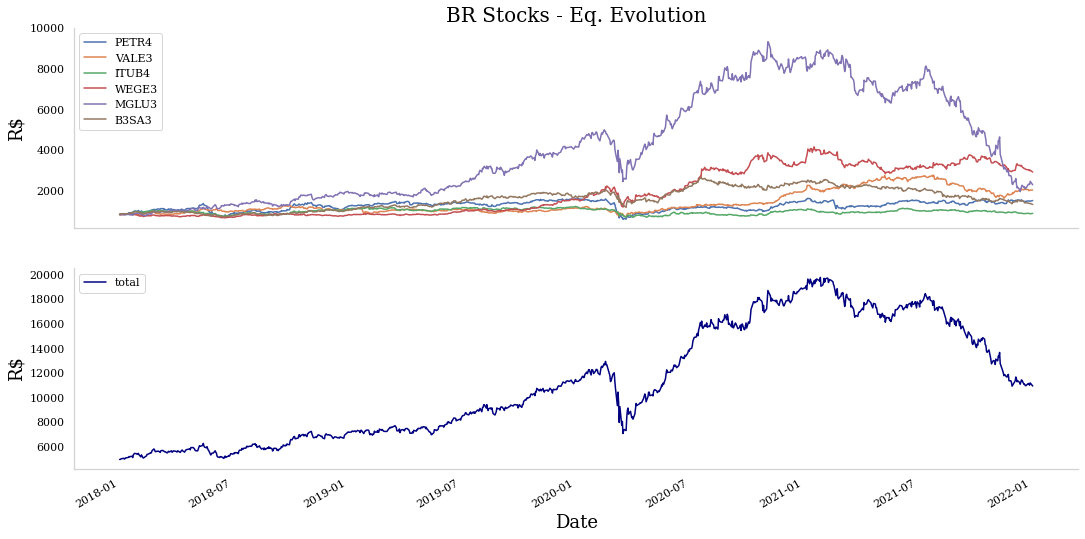

In [3]:
eq_br = ew_br.equity
fig, (ind_eq, total_eq) = plt.subplots(
    nrows=2, ncols=1, sharex=True,
    figsize=(18, 9)
)
plt.subplots_adjust(wspace=0.0)

eq_br.get_total_equity(False).plot(
    ax=ind_eq,
    title='BR Stocks - Eq. Evolution',
    ylabel='R$'
)
ind_eq.set_ylim(top=10_000)
ind_eq.legend(loc='upper left')

eq_br.get_total_equity().plot(
    ax=total_eq,
    ylabel='R$',
    color='navy',
    label='total'
)
total_eq.legend(loc='upper left');

The `Equity` class is useful when calculating returns and the perform long and short operations. For now, we focus on the former. For instance, it calculates returns by considering the change in the weights distribution with time. As an asset gain or lose value, its weight will change and, accordingly, so change the remaining weights. As a result, one cannot consider the simple product of the initial weights with the price variation, as this assumes the weights to remain unaltered throughout the period. Below we compare both versions of calculation and we explicitly observe that, the greater the difference between the current weight and its initial value, the farther apart the returns will be.

The `acm_returns()` `Portfolio` method implicitly uses the `weights_track()` `Equity` method, which precisely keeps track of the weight evolution in the period.

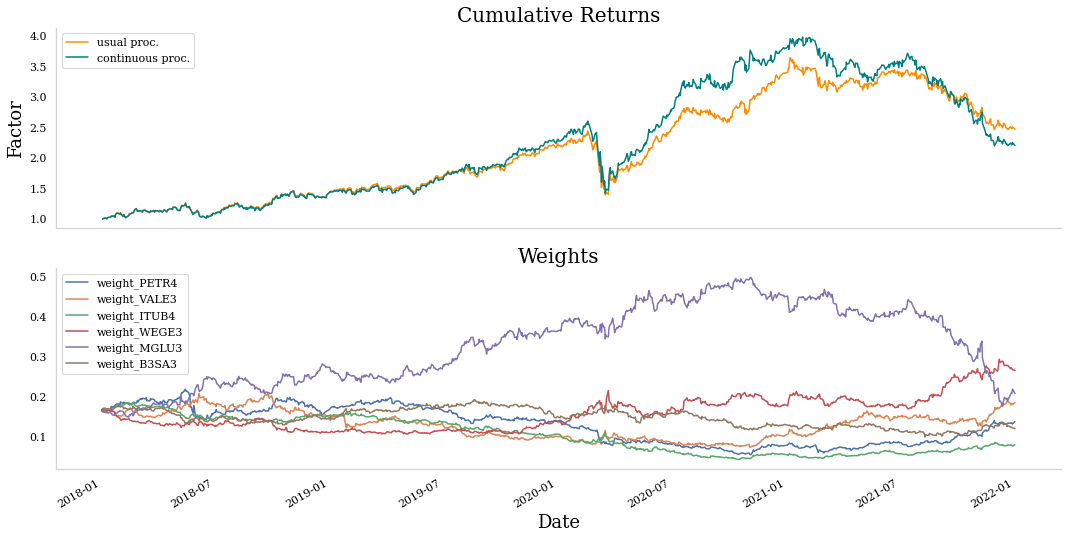

In [4]:
# usual procedure
d_ret = ew_br.prices.pct_change().dropna()
d_ret_pf = (d_ret * ew_br.init_weights).sum(axis=1)
acm_pf = (1 + d_ret_pf).cumprod()

fig, (acm_ax, w_ax) = plt.subplots(
    nrows=2, ncols=1, sharex=True,
    figsize=(18, 9)
)
plt.subplots_adjust(wspace=0.0)

acm_pf.plot(
    ax=acm_ax,
    color='darkorange',
    label='usual proc.'
)

# continuous procedure
ew_br.acm_returns().plot(
    ax=acm_ax, color='teal',
    label='continuous proc.'
)
acm_ax.set_title('Cumulative Returns')
acm_ax.set_ylabel('Factor')
acm_ax.legend(loc='upper left')

eq_br.weights_track().plot(
    ax=w_ax
)
w_ax.set_title('Weights');

We can even compute the RMSE between them, to obtain a difference of $23.56 \%$

In [5]:
qt.rmse(
    ew_br.acm_returns(),
    acm_pf
)

0.23562784768294642

With the `asset_returns()` method, we get---in this case---the annualized returns of each asset, and plot them with the `plot_returns_sns` function, which uses different colors for negative and positive returns and automatically sorts them in asceding order.

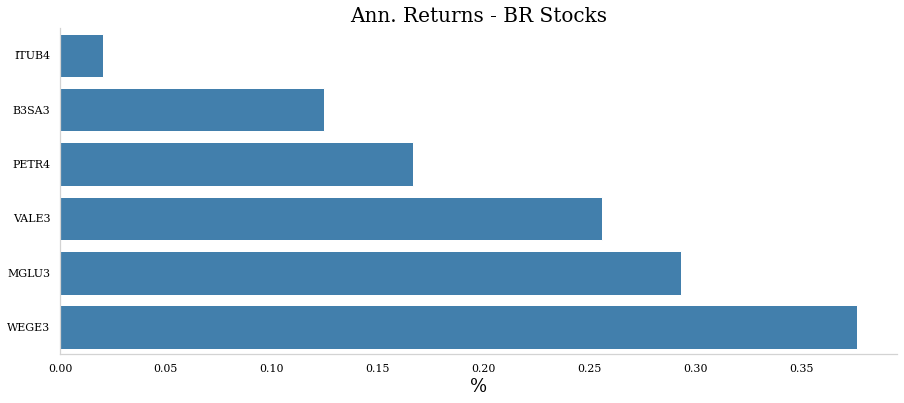

In [5]:
qt.plot_returns_sns(
    rets=ew_br.asset_returns(),
    titles=['Ann. Returns - BR Stocks', '%', None],
    size=(15, 6)
)

The `var()` and `cvar()` methods give us VaR and CVaR of the return distribution (daily, monthly or annual), respectively. By default, they use the daily returns and compute the historical values. With the `kind` and `period` parameters, one can choose among historical and parametric calculation and which return to consider, respetively. To exhibit both the VaR and CVaR, we have considered the histogram of the daily returns below.

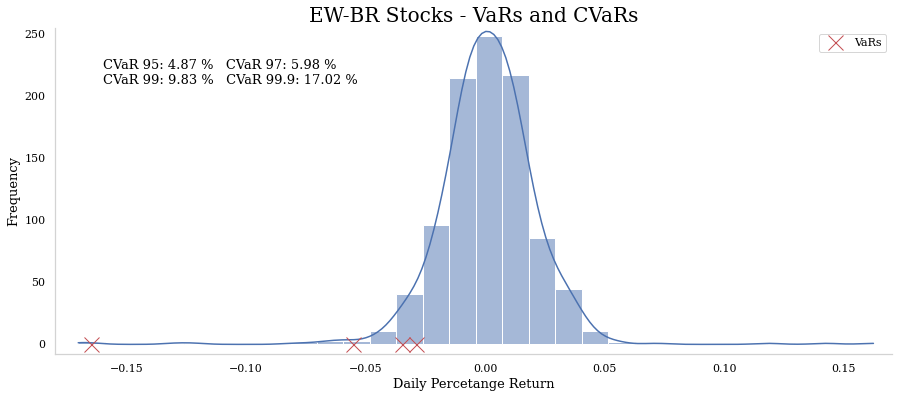

In [6]:
vars_hist = ew_br.var(period='d')  # use period='m' for monthly data
cvars_hist = ew_br.cvar(period='d')

fig, ax = plt.subplots(figsize=(15, 6))

sns.histplot(
    data=ew_br.d_returns(),  # use m_returns() for monthly data
    kde=True,
    bins=30
)

plt.plot(
    vars_hist.values,
    [0, 0, 0, 0],
    'x',
    markersize=15,
    color='r',
    label='VaRs'
)

# plt.axis([-.25, .22, -.5, 8])  # for monthly data
plt.axis([-.18, .17, -8, 255])
t = (
    f'CVaR 95: {cvars_hist.loc[95] * 100:.2f} %'
    f'   CVaR 97: {cvars_hist.loc[97] * 100:.2f} %'
    f'\nCVaR 99: {cvars_hist.loc[99] * 100:.2f} %'
    f'   CVaR 99.9: {cvars_hist.loc[99.9] * 100:.2f} %'
)

# ax.text(-.22, 6, t, fontdict={'size': 13})  # for monthly data
ax.text(-.16, 210, t, fontdict={'size': 13})

plt.legend()
plt.title(f'EW-BR Stocks - VaRs and CVaRs')
plt.xlabel('Daily Percetange Return', fontdict={'size': 13})
plt.ylabel('Frequency', fontdict={'size': 13});

We can also get the mean confidence interval from the return distribution, which yields its mean and the lower and upper bounds of the confidence interval ($95 \%$ by default).

In [8]:
qt.mci(ew_br.d_returns())

(0.0010356069225486604, -0.0003143002051464699, 0.002385514050243791)

As the historical estimates for the VaR and CVaR are highly affected by the sample data and the period under study, it is insightful to look at the parametric versions. Howeverm as we are aware the a return distribution does not assume, in general, a normal distribution, one ought to consider the adjusted version, as well. The `all_vars()` method has been constructed to precisely attend this demand.

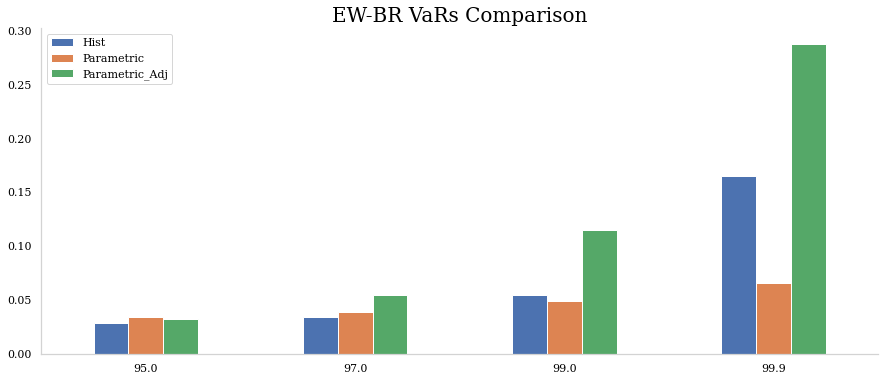

In [7]:
ew_br.all_vars().plot.bar(
    figsize=(15, 6),
    title='EW-BR VaRs Comparison',
    rot=0
);

The `quant_tools` module has a function to exhibit, in a more interesting fashion, a portfolio monthly returns. By default, it uses different colors for negative and positive returns and also shows the mean and median of the distribution.

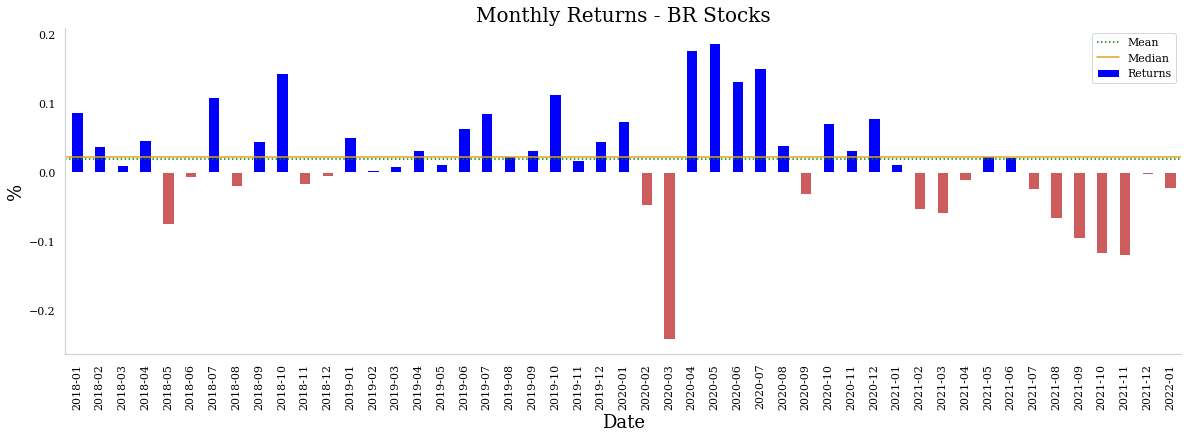

In [10]:
qt.plot_monthly_returns(
    ew_br.m_returns(),
    title='Monthly Returns - BR Stocks',
    size=(20, 6)
)

In [11]:
qt.mci(ew_br.m_returns())

(0.01940650069342466, -0.003461225715905833, 0.042274227102755156)

### 1.1.1 Volatilities

As it so happens, a portfolio volatility relies on the weight distribution of its assets and, as we have seen, it may not remain constant throughout the period. The `volatility()` `Portfolio` method implicitly uses the `weights_track()` Equity method to account for this fact. As a result, the volatility takes on many values and we can plot a histogram for its distribution (by setting the `tracking` paramter as `True`, the method returns a pd.Series). We multiply the outcome by $\sqrt{21}$ to look at monthly volatility.

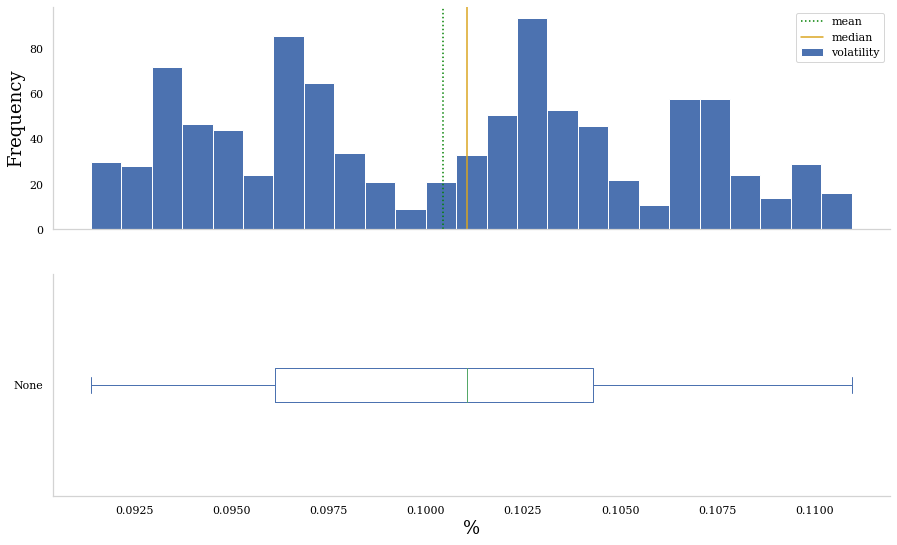

In [8]:
vol_track = ew_br.volatility(tracking=True) * np.sqrt(21)

fig, (hist_ax, box_ax) = plt.subplots(
    nrows=2, ncols=1, sharex=True,
    figsize=(15, 9)
)
plt.subplots_adjust(wspace=0.0)

vol_track.plot.hist(ax=hist_ax, bins=25, label='volatility')
hist_ax.axvline(vol_track.mean(), ls=':', color='green', label='mean')
hist_ax.axvline(vol_track.median(), ls='-', color='goldenrod', label='median')
hist_ax.legend()

vol_track.plot.box(ax=box_ax, vert=False)
plt.xlabel('%');

On the other hand, we can use the default value for the `tracking` parameter to obtain the median (or the mean, controlled with the `measure` parameter) of the volatility distribution. Further, through the `is_portfolio` parameter one has access to the portfolio volatility and the assets' individual volatilities.

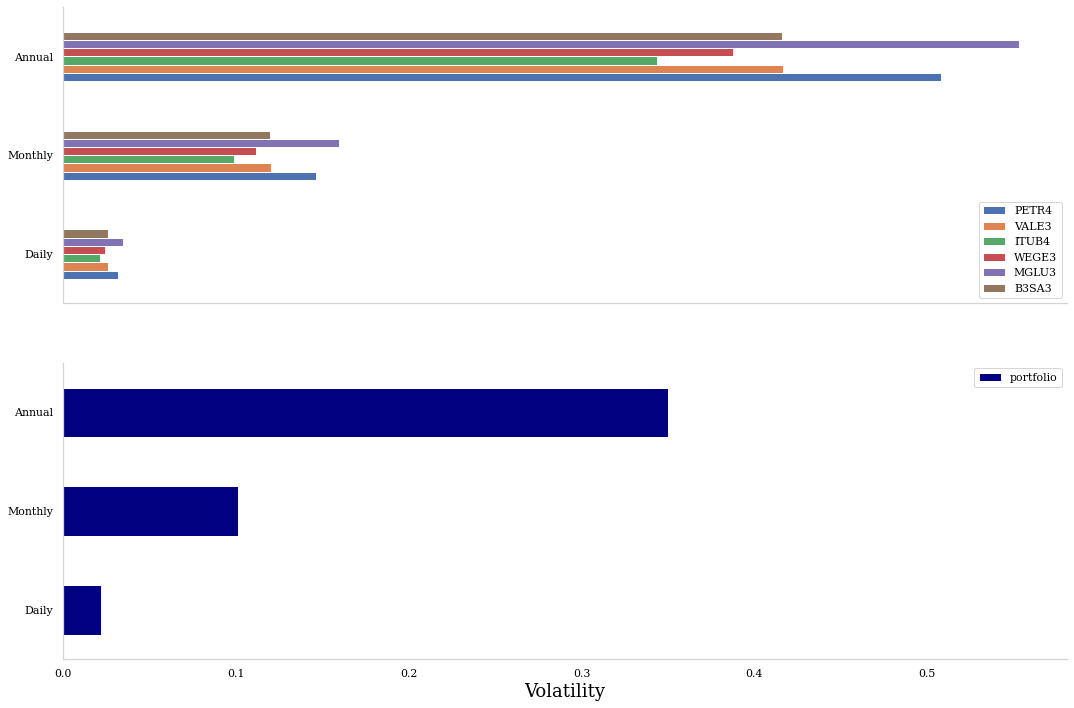

In [9]:
fig, (ind_vol, pf_vol) = plt.subplots(
    nrows=2, ncols=1, sharex=True,
    figsize=(18, 12)
)
plt.subplots_adjust(wspace=0.0)

ew_br.volatility(is_portfolio=False).plot.barh(
    ax=ind_vol
)
ew_br.volatility(is_portfolio=True).plot.barh(
    ax=pf_vol,
    color='navy',
    label='portfolio'
)
plt.legend()
plt.xlabel('Volatility');

In [91]:
print('Individual volatilies:')
display(ew_br.volatility(is_portfolio=False))

print('Portfolio volatility:')
display(ew_br.volatility())

Individual volatilies:


,PETR4,VALE3,ITUB4,WEGE3,MGLU3,B3SA3
Daily,0.032006,0.026222,0.021664,0.024429,0.034842,0.026203
Monthly,0.146671,0.120163,0.099276,0.111948,0.159667,0.120076
Annual,0.508085,0.416256,0.343902,0.387800,0.553104,0.415956


Portfolio volatility:


Daily      0.022057
Monthly    0.101076
Annual     0.350138
dtype: float64

The `plot_heat_sns` function easily plots a heatmap of the correlation between the assets.

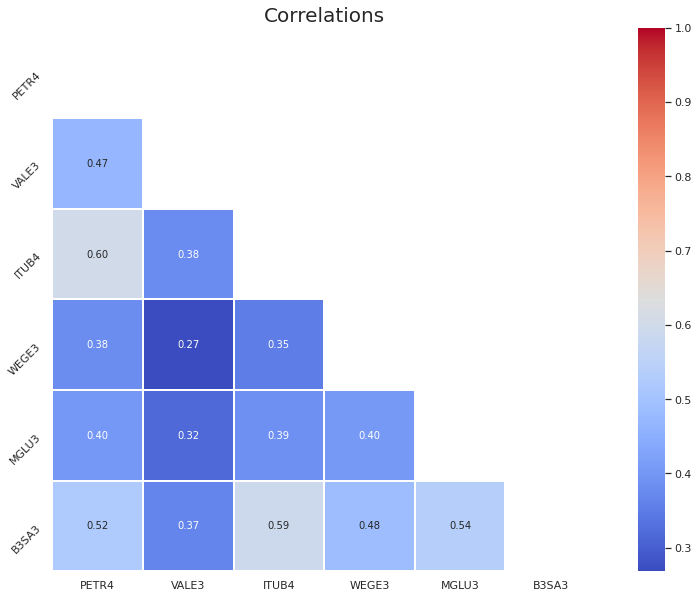

In [13]:
qt.plot_heat_sns(ew_br.d_returns(is_portfolio=False), size=(15, 10), rotate=True)

### 1.1.2 Benchmark and Risk-Free Rate - IBOV and Selic

We will download the data from a BR market index, IBOV, considering the same period, and pass it to an empty `Portfolio` object. To do it, however, we need to set, in this case, the `init_inv` parameter to $80.000$ so as to be able to purchase "one share" of the market index. (I intend to improve this feature in future versions.)

Hence:

1. one downloads the data separately and save it to a variable (`ibvp_`): the `market_index` function is able to gather data from IBOV and IFIX;
2. declares an empty `Portfolio` (`ibvp`) by informing just its name and its asset list (no dates!);
3. set the `prices` attribute of the empty `Portfolio` to the variable with the sample data acquired earlier;
4. set the `dates` attribute to the period under consideration (the same period within which the data has been downloaded);
5. register the `Portfolio` object so as to include it in the `Portfolio.registered` dictionary.

In [10]:
ibvp_ = qt.market_index('bvsp', start_dt, end_dt)

ibvp = Portfolio('IBVP', ['BVSP'], init_inv=80_000)
ibvp.prices = ibvp_
ibvp.dates = (start_dt, end_dt)
Portfolio.register(ibvp)
del ibvp_

ibvp.prices

,BVSP
Date,
2018-01-02,77891.0
2018-01-03,77995.0
2018-01-04,78647.0
2018-01-05,79071.0
2018-01-08,79379.0
...,...
2021-12-27,105554.0
2021-12-28,104864.0
2021-12-29,104107.0


The `selic` function gathers monthly data from the SELIC brazilian interest rate. With the `is_number` parameter, one can choose to receive either a pd.Series with the monthly data or its "periodized" mean, set through the `period` parameter (annual by default).

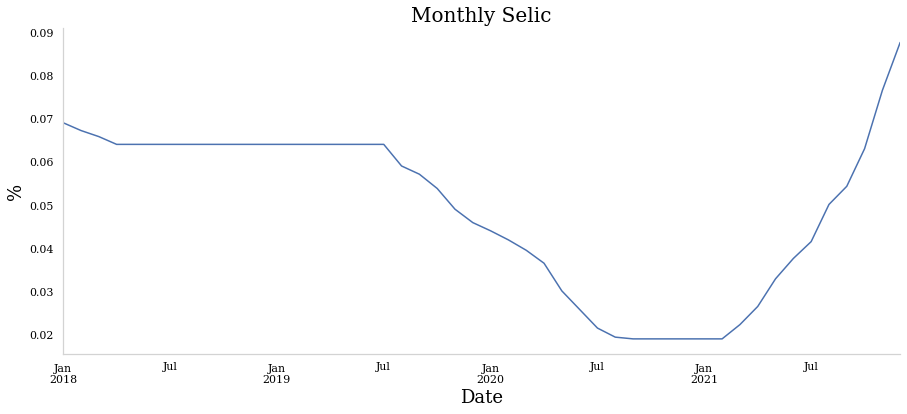

In [3]:
selic_a = qt.selic(start_dt, end_dt, is_number=False)
selic_a.plot(
    figsize=(15, 6),
    title='Monthly Selic',
    ylabel='%'
);

With `is_number` as `True`, we now have the risk-free rate asset concerning the BR investment that, along with the IBOV benchmark, we can call the `metrics` `Portfolio` method to evaluate several indicators of interest.

In [11]:
selic_a = qt.selic(start_dt, end_dt, is_number=True)
ew_br.metrics(
    risk_free_rate=selic_a,
    window=21,
    period='d',
    benchmark=ibvp
)

,EW-BR
Ann_Return,0.222965
Ann_Volatility,0.350138
Sharpe_Ind,0.602376
Sortino_Ind.,0.770791
Beta,1.070152
Skewness (d),-0.613471
Ex_Kurtosis (d),11.671979
VaR_99.9 (d),0.164963
CVaR_99.9 (d),0.170223
Max_Drawdown (21),-0.452983


Finally, we can use the `benchmark` method to compare the cumulative returns between the object calling it and the objects passed as a list.

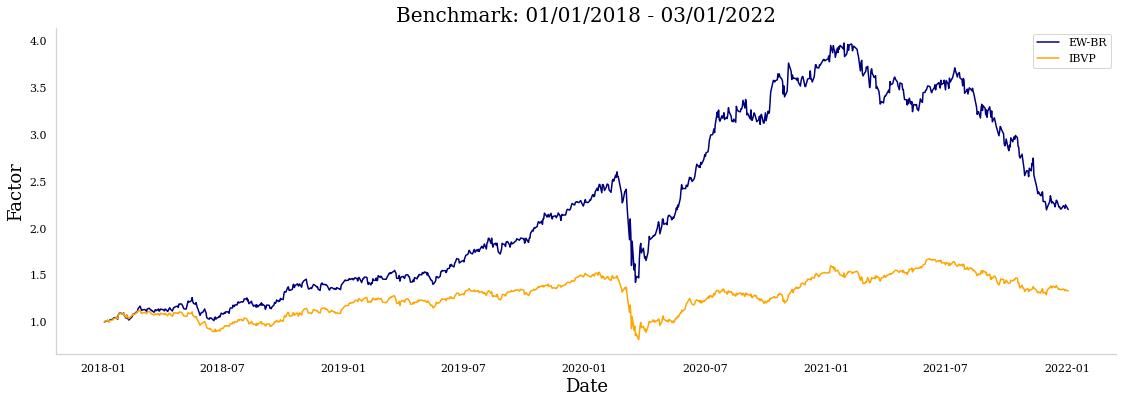

In [12]:
ew_br.benchmark(
    [ibvp],
    linewidth=1.5,
    dashes=False,
    palette=['navy', 'orange']
)

## 1.2 Optimizations

We now perform some simple and naïveoptimizations to demonstrate how to use the `transfer` method. From the `quant_tools` module we have access to the GMV (Global Minimum Variance), the minimum volatility and the MSR (Maximum Sharpe Ratio) portfolios. The first relies only on the covariance matrix whereas the other two request expected returns as well. As our goal here is to simply demonstrate the `transfer` method, we use as expected returns the actual returns obtained in the period (given by the `asset_returns()` method) and the sample covariance as the covariance matrix.

The `transfer` method receives a name and a weight vector as inputs and returns a `Portfolio` object with such name and initial weights. The resulting object is, in fact, a copy of the object that has called the method, such that the original assets list, prices dataframe and dates will be transfered to the it. Once that is done, the transfered object will have its name and initial weights changed to parameters given as inputs. Thus, we obtain the optimized weights and call the `transfer` method to build a new portfolio. This is useful for comparing portfolios in similar periods, but with different initial allocations.

### 1.2.1 Global Minimum Variance Portfolio

In [13]:
exp_r = ew_br.asset_returns()
cov = ew_br.sample_cov()

# weights for the gmv portfolio
w_gmv = qt.gmv(cov)

# declaring a new portfolio with the same
# assets list, prices dataframe and dates
# that ew_br, but with w_gmv as init_weights
gmv = ew_br.transfer('GMV', w_gmv)

pd.Series(
    w_gmv,
    index=exp_r.index
).round(4)

PETR4    0.0000
VALE3    0.2390
ITUB4    0.4196
WEGE3    0.3156
MGLU3    0.0036
B3SA3    0.0221
dtype: float64

### 1.2.2. Portfolio of Minimum Volatility, given a target return

In [14]:
# exp_r = ew_br.asset_returns()
# cov = ew_br.sample_cov()

# minimizing the volatility for a target return
# of 30%
w_min = qt.minimize_vol(.3, exp_r, cov)
min_v = ew_br.transfer('Min. Vol.', w_min)

pd.Series(
    w_min,
    index=exp_r.index
).round(4)

PETR4    0.0000
VALE3    0.3210
ITUB4    0.0942
WEGE3    0.5336
MGLU3    0.0512
B3SA3    0.0000
dtype: float64

### 1.2.3. Maximum Sharpe Ratio (MSR) Portfolio

In [15]:
# exp_r = ew_br.asset_returns()
# cov = ew_br.sample_cov()
w_msr = qt.maximize_sr(exp_r, cov, selic_a)
msr = ew_br.transfer('MSR', w_msr)

pd.Series(
    w_msr,
    index=exp_r.index
).round(4)

PETR4    0.0000
VALE3    0.2707
ITUB4    0.0000
WEGE3    0.6900
MGLU3    0.0393
B3SA3    0.0000
dtype: float64

With the optimized portfolios at hand, we can perform a benchmark to see the difference.

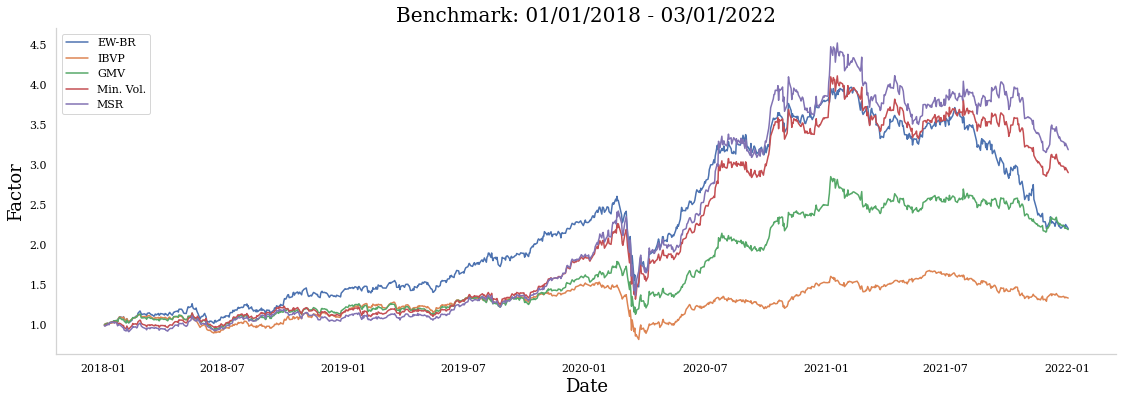

In [16]:
ew_br.benchmark(
    [ibvp, gmv, min_v, msr],
    linewidth=1.5,
    dashes=False
)

Finally, the `all_metrics()` class method gathers all the metrics from the portfolios informed.

In [17]:
Portfolio.all_metrics(
    [ibvp, ew_br, gmv, min_v, msr],
    risk_free_rate=selic_a,
    benchmark=ibvp
)

,IBVP,EW-BR,GMV,Min. Vol.,MSR
Ann_Return,0.076233,0.222965,0.221135,0.311954,0.343856
Ann_Volatility,0.2849,0.350138,0.28346,0.313684,0.329876
Sharpe_Ind,0.225284,0.602376,0.737618,0.956069,1.00585
Sortino_Ind.,0.269141,0.770791,0.914302,1.158135,1.247133
Beta,1.0,1.070152,0.872056,0.855299,0.823117
Skewness (d),-0.999492,-0.613471,-0.903457,-1.085306,-0.919569
Ex_Kurtosis (d),13.037771,11.671979,6.440828,9.165832,8.509467
VaR_99.9 (d),0.139318,0.164963,0.134542,0.156765,0.159311
CVaR_99.9 (d),0.147797,0.170223,0.14419,0.172355,0.184631
Max_Drawdown (21),-0.44522,-0.452983,-0.368743,-0.417099,-0.435092


## 1.3 Why register?

The goal of registering `Portfolios` (automatically made when creating a non-empty object) is that we can further compare them. For example, we have, as class methods:

1. `all_rets()` - returns the annualized return of all the registered `Portfolio`'s
2. `all_vols()` - returns the annualized volatility of all the registered `Portfolio`'s
3. `all_sindex()` - returns the annualized Sharpe ratio of all the registered `Portfolio`'s

From such methods, along with the `plot_opt_comparison()` function from the `quant_tools` module, we can easily plot the following graph.

In [23]:
# we have the Portfolio's name as key and the
# Portfolio itself (memory) as values
Portfolio.registered

{'EW-BR': <portfolio_class.Portfolio at 0x7f7d00985790>,
 'IBVP': <portfolio_class.Portfolio at 0x7f7cfc475a90>,
 'GMV': <portfolio_class.Portfolio at 0x7f7cfc32f940>,
 'Min. Vol.': <portfolio_class.Portfolio at 0x7f7cfc57bd00>,
 'MSR': <portfolio_class.Portfolio at 0x7f7cfde710a0>}

In [22]:
rets = Portfolio.all_rets()
vols = Portfolio.all_vols()
sharpes = Portfolio.all_sindex(selic_a)

r_colors = map(
    lambda r: 'red' if r < ew_br.portfolio_return() else 'blue',
    rets
)

v_colors = map(
    lambda v: 'blue' if v < ew_br.volatility()['Annual'] else 'red',
    vols
)

s_colors = map(
    lambda s: 'red' if s < ew_br.s_index(selic_a) else 'blue',
    sharpes
)

colors = {
    'rets': list(r_colors),
    'vols': list(v_colors),
    'sharpes': list(s_colors)
}

# this plot is only rendered with plotly
qt.plot_opt_comparisons(rets, vols, sharpes, colors)

## 1.4 Efficient Frontier

As a final application of this section, we show the efficient frontier for the BR assets list. The frontier is built with minimum volatility portfolios, given a return. It considers `n_points` within the range [smallest expected return, greatest expected return] and finds the minimum volatility portfolio for each return. One can also ask the function to show the GMV and the EW portfolios, as well as the market line (line that connects the risk-free rate with the MSR portfolio), which, in fact, is the true efficient frontier when risk-free assets are considered. For instance, instead of having the GMV portfolio (blue dot), with approximately 4% return and 18% volatility, one can allocate between the MSR portfolio and the risk-free asset (the portfolio thus lying in the market capital line) to achieve the same return over 10% volatility.

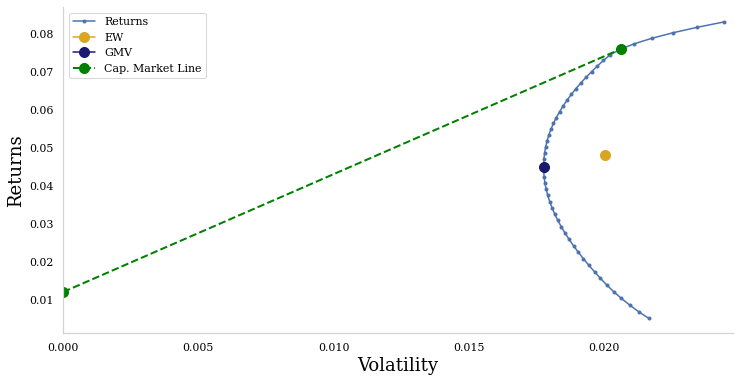

In [31]:
# exp_r = ew_br.asset_returns()
# cov = ew_br.sample_cov()

qt.plot_eff(
    exp_rets=exp_r, cov=cov,
    n_points=50, n_years=4,
    risk_free_rate=selic_a,
    show_cml=True, show_ew=True,
    show_gmv=True
)

## 2. US Stocks

For this section we focus on the `Equity` class, in particular, on its `operation` method. One is free to repeat the above analysis, now concerning the US stocks, to see how they differ in quantitative terms. As this would only repeat the code, we do not perform it here.

The stocks under consideration are (same period)

- AAPL (Apple)
- MSFT (Microsoft)
- VZ (Verizon)
- KO (Coca-Cola)
- NKE (Nike)
- V (VISA)

We proceed analogously as the BR stocks: first declare a `Portfolio` object (notice the `us` parameter).

In [36]:
assets_us = [
    'AAPL', 'MSFT', 'VZ',
    'KO', 'NKE', 'V'
]

ew_us = Portfolio(
    'EW-US',
    assets_us,
    init_inv=5000.,
    start=start_dt,
    end=end_dt,
    source='iv',
    us=True
)

# dump(ew_us, 'ew_us.pkl')
# ew_us = load('ew_us.pkl')
# Portfolio.register(ew_us)

ew_us.prices

,AAPL,MSFT,VZ,KO,NKE,V
Date,,,,,,
2018-01-02,43.06,85.95,53.53,45.54,63.49,114.51
2018-01-03,43.06,86.35,52.43,45.44,63.48,115.65
2018-01-04,43.26,87.11,52.60,46.08,63.44,116.08
2018-01-05,43.75,88.19,52.48,46.07,63.98,118.86
2018-01-08,43.59,88.28,52.39,46.00,64.55,119.34
...,...,...,...,...,...,...
2021-12-28,179.29,341.25,52.72,58.88,166.42,218.05
2021-12-29,179.38,341.95,52.36,58.95,168.78,218.17
2021-12-30,178.20,339.32,52.25,58.78,167.49,217.87


### 2.1 Operations

We access the `Equity` class from the `equity` attribute. From it, we easily obtain the number of shares that the initial investment ($5.000$ in this case) has acquired, as well as the initial allocations. As, by default, the initial weights are equally distributed, we observe a similar allocation among the assets.

In [19]:
eq_us = ew_us.equity

print('Number of shares on US stocks:')
display(eq_us.n_shares)

print('Initial allocation on US stocks:')
display(eq_us.init_allocations)

Number of shares on US stocks:


AAPL    19
MSFT     9
VZ      15
KO      18
NKE     13
V        7
dtype: int32

Initial allocation on US stocks:


AAPL    818.14
MSFT    773.55
VZ      802.95
KO      819.72
NKE     825.37
V       801.57
dtype: float64

From the `eq_history` property we observe the operations (long or short) that have been made in the portfolio, in the form of a dictionary, with the corresponding dates as keys, and another dictionary with the assets as keys and a tuple containing the amount of capital invested or sold and the equivalent in shares, as values. When we declare a `Portfolio`, an operation is already taking place: the initial allocation. Thus:

In [20]:
eq_us.eq_history

{'2018-01-02': {'AAPL': (818.1400000000001, 19),
  'MSFT': (773.5500000000001, 9),
  'VZ': (802.95, 15),
  'KO': (819.72, 18),
  'NKE': (825.37, 13),
  'V': (801.57, 7)}}

Operations can be performed by calling the `operation` method from the `equity` attribute. One must inform, as a dictionary with the assets of interest (that will be operated) as keys and their corresponding capital as values, along with the date that the operation will occur.

For instance, in the first operation below we are investing $300$ in VZ and $500$ in V in 2018/06/01. In the second, we are investing $250$ in KO and $800$ in NKE in 2018/08/01. The third is analogous. In the fourth, we are now selling $1000$ in AAPL, $500$ in MSFT and $500$ in VZ in 2020/01/02. The method automatically updates the `eq_history` property and, when a short operation is made, it informs us the profits.

In [21]:
eq_us.operation(
    {'VZ': 300, 'V': 500},
    '2018-06-1'
)
eq_us.operation(
    {'KO': 250, 'NKE': 800},
    '2018-08-1'
)
eq_us.operation(
    {'AAPL': 1000, 'MSFT': 1000},
    '2018-10-1'
)
eq_us.operation(
    {'AAPL': 1000, 'MSFT': 500, 'VZ': 500},
    '2020-01-02',
    sell=True
)
eq_us.eq_history

Profit AAPL: 204.47%
Profit MSFT: 223.23%
Profit VZ: 95.58%


{'2018-01-02': {'AAPL': (818.1400000000001, 19),
  'MSFT': (773.5500000000001, 9),
  'VZ': (802.95, 15),
  'KO': (819.72, 18),
  'NKE': (825.37, 13),
  'V': (801.57, 7)},
 '2018-06-1': {'AAPL': (0.0, 0.0),
  'MSFT': (0.0, 0.0),
  'VZ': (286.86, 6.0),
  'KO': (0.0, 0.0),
  'NKE': (0.0, 0.0),
  'V': (392.55, 3.0)},
 '2018-08-1': {'AAPL': (0.0, 0.0),
  'MSFT': (0.0, 0.0),
  'VZ': (0.0, 0.0),
  'KO': (231.95, 5.0),
  'NKE': (775.4, 10.0),
  'V': (0.0, 0.0)},
 '2018-10-1': {'AAPL': (965.77, 17.0),
  'MSFT': (924.88, 8.0),
  'VZ': (0.0, 0.0),
  'KO': (0.0, 0.0),
  'NKE': (0.0, 0.0),
  'V': (0.0, 0.0)},
 '2020-01-02': {'AAPL': (-976.17, 13.0),
  'MSFT': (-481.86, 3.0),
  'VZ': (-488.4, 8.0),
  'KO': (-0.0, 0.0),
  'NKE': (-0.0, 0.0),
  'V': (-0.0, 0.0)}}

When an operation is performed, the portfolio equity is also automatically updated, which can be seen from the `get_total_equity()` method. Setting `total` to `False`, we obtain the individual equities. By showing only the year upon which the operation has been performed, we see more clearly the increase on the corresponding equities.

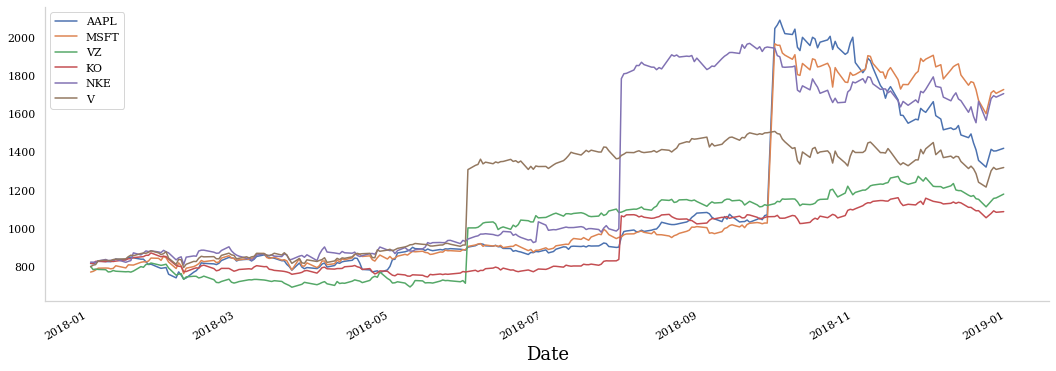

In [22]:
eq_us.get_total_equity(total=False)['2018'].plot(
    figsize=(18, 6)
);

The same is true for the weights distribution.

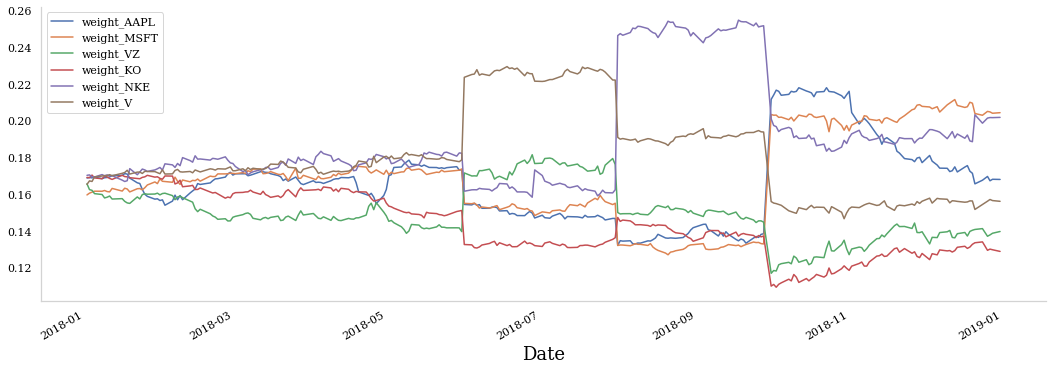

In [23]:
eq_us.weights_track()['2018'].plot(
    figsize=(18, 6)
);

Here we show the entire period and also demonstrate the `avg_track()` method, which keeps tracks the average price of each investment. As there were no further short operations after 2018, we see it remains constant thenceforth.

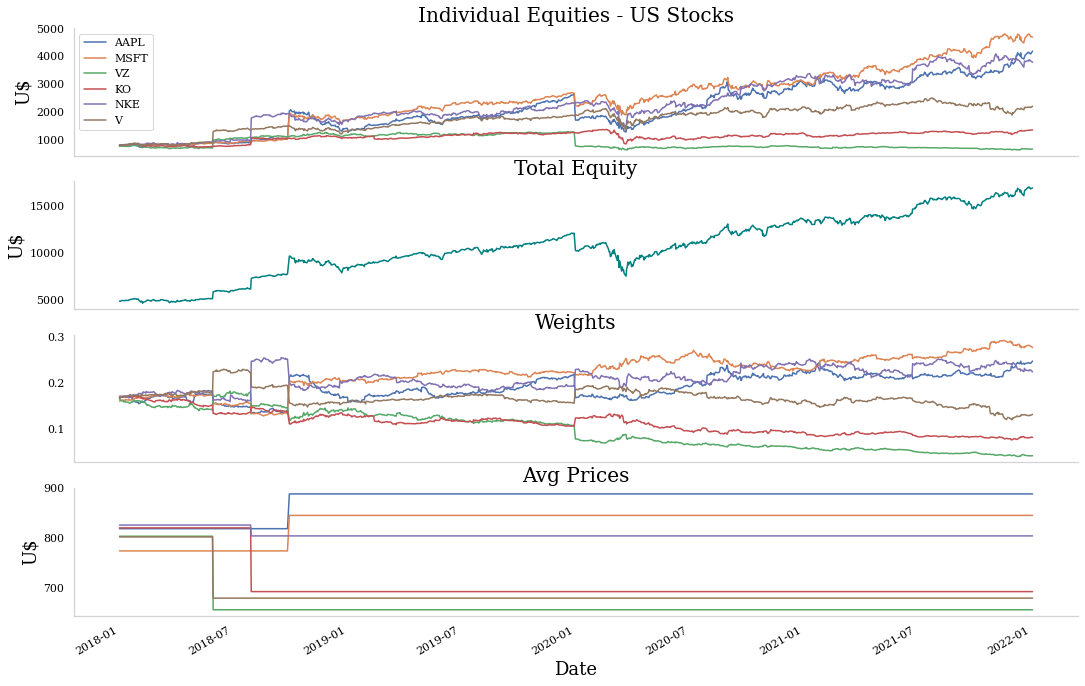

In [24]:
fig, (eq_ind_ax, eq_total_ax, w_ax, avg_ax) = plt.subplots(
    nrows=4, ncols=1, sharex=True,
    figsize=(18, 12)
)
plt.subplots_adjust(wspace=0.0)

eq_us.get_total_equity(False).plot(
    ax=eq_ind_ax,
)
eq_ind_ax.set_title('Individual Equities - US Stocks')
eq_ind_ax.set_ylabel('U$')
eq_ind_ax.legend(loc='upper left')

eq_us.get_total_equity().plot(
    ax=eq_total_ax, color='teal'
)
eq_total_ax.set_title('Total Equity')
eq_total_ax.set_ylabel('U$')

eq_us.weights_track().plot(
    ax=w_ax, legend=False
)
w_ax.set_title('Weights')

eq_us.avg_track().plot(
    ax=avg_ax, legend=False
)
avg_ax.set_title('Avg Prices')
avg_ax.set_ylim(top=900)
avg_ax.set_ylabel('U$');

One can also see the current individual average prices with `avg_prices()`.

In [29]:
eq_us.avg_prices()

{'AAPL': 887.8541666666666,
 'MSFT': 844.7641176470589,
 'VZ': 655.4957142857143,
 'KO': 691.9439130434783,
 'NKE': 803.6439130434782,
 'V': 678.8640000000001}

## 3. Global Portfolio: BR + US Stocks

We now show the effect of `Portfolio` addition: `p = p1 + p2`. It actually simply concatenates (with an inner join) the prices dataframe of the `Portfolio`'s being added and registers the resulting `Portfolio` under the name `p1.name + p2.name`. In our case, we sum the BR portfolio with the US portfolio and name it as EW-Global, which is why we unregister the name 'EW-BR + EW-US'.

In [25]:
ew_gbl = ew_br + ew_us
ew_gbl.name = 'EW-Global'
Portfolio.unregister('EW-BR + EW-US')
Portfolio.registered

{'EW-BR': <portfolio_class.Portfolio at 0x7f064f9bf0a0>,
 'IBVP': <portfolio_class.Portfolio at 0x7f064f6237f0>,
 'GMV': <portfolio_class.Portfolio at 0x7f064e5f5c70>,
 'Min. Vol.': <portfolio_class.Portfolio at 0x7f064f23ffd0>,
 'MSR': <portfolio_class.Portfolio at 0x7f064f6a8ac0>,
 'EW-US': <portfolio_class.Portfolio at 0x7f064dace580>,
 'EW-Global': <portfolio_class.Portfolio at 0x7f064f176ac0>}

Like any new `Portfolio`, the initial weight distribution is uniform. Notice, however, that an error may be raised when considering the initial investment of `p1` with all the assets from the resulting `Portfolio`. That is, if `p1.init_inv` $= \$ \, 1000$ with in $5$ assets, when we add it to `p2`, with another set of assets, $\$ \, 1000$ may not suffice. To this end, the addition method considers the minimum allocation required to build the resulting `Portfolio`. If this value is smaller (greater) than `p1.init_inv`, the latter (former) will be used.

In [26]:
ew_gbl.init_weights

array([0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.08333333,
       0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.08333333,
       0.08333333, 0.08333333])

In [27]:
eq_gbl = ew_gbl.equity
eq_gbl.init_allocations

PETR4    412.88
VALE3    414.31
ITUB4    397.40
WEGE3    411.30
MGLU3    416.50
B3SA3    412.36
AAPL     387.54
MSFT     343.80
VZ       374.71
KO       409.86
NKE      380.94
V        343.53
dtype: float64

To conclude, as the global portfolio consists of 50% of BR and US stocks, we build a benchmark consisting of 50% of SP500 and IBOV. We first download the data from SP500.

In [28]:
sp500 = Portfolio(
    'SPXI11',
    ['SPXI11'],
    start=start_dt,
    end=end_dt,
    source='yf'
)
sp500.prices

,SPXI11
Date,
2018-01-02,90.37
2018-01-03,90.39
2018-01-04,90.55
2018-01-05,90.94
2018-01-08,91.57
...,...
2021-12-23,285.00
2021-12-27,286.13
2021-12-28,286.49


We now construct the prices dataframe as below: given the weight vector `np.array([0.5, 0.5])`, we multiply it by the concatenated dataframe of the SP500 and IBOV prices and sum in the column axis.

In [29]:
bmk_weights = np.array([.5, .5])

aux = pd.concat(
    [sp500.prices, ibvp.prices],
    axis=1,
    join='inner'
)
aux = (aux * bmk_weights).sum(axis=1).to_frame()
aux.rename(columns={0: 'SP500 + IBVP'}, inplace=True)
aux

,SP500 + IBVP
Date,
2018-01-02,38990.685
2018-01-03,39042.695
2018-01-04,39368.775
2018-01-05,39580.970
2018-01-08,39735.285
...,...
2021-12-23,52588.000
2021-12-27,52920.065
2021-12-28,52575.245


As the first price is $38.990$, we consider an empty `Portfolio` with initial investment of $40.000$ and set the `prices` property.

In [38]:
bmk_gbl = Portfolio('SP500 + IBVP', ['SP500 + IBVP'], init_inv=40_000)
bmk_gbl.prices = aux
bmk_gbl.dates = (start_dt, end_dt)

# dump(bmk_gbl, 'bmk_gbl.pkl')
# bmk_gbl = load('bmk_gbl.pkl')
# Portfolio.register(bmk_gbl)

bmk_gbl.prices

,SP500 + IBVP
Date,
2018-01-02,38990.68
2018-01-03,39042.70
2018-01-04,39368.78
2018-01-05,39580.97
2018-01-08,39735.29
...,...
2021-12-23,52588.00
2021-12-27,52920.06
2021-12-28,52575.24


With above `Portfolio` as benchmark, we can call the `metrics` method to compute the indicators. For simplicity, we asume the risk-free rate is still the selic rate. Afterwards, the cumulative returns are exhibited.

In [31]:
ew_gbl.metrics(
    risk_free_rate=selic_a,
    period='d',
    benchmark=bmk_gbl
)

,EW-Global
Ann_Return,0.247049
Ann_Volatility,0.274685
Sharpe_Ind,0.855521
Sortino_Ind.,1.037394
Beta,0.834852
Skewness (d),-0.755109
Ex_Kurtosis (d),15.441008
VaR_99.9 (d),0.13989
CVaR_99.9 (d),0.144778
Max_Drawdown (21),-0.381667


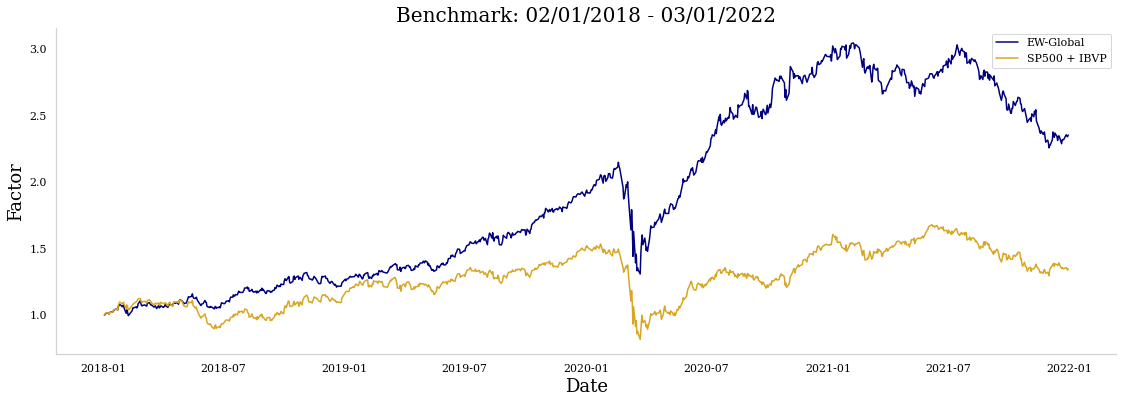

In [32]:
ew_gbl.benchmark(
    [bmk_gbl],
    linewidth=1.5,
    dashes=False,
    palette=['navy', 'goldenrod']
)